In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets.datasets import naturalscenes
from sparsecoding import inference
# from utils import plotmontage 
import torch
import time

In [4]:
lca = inference.LCA()

### Define constants and load data

In [19]:
patch_size = 16
batch_size = 100
patch_overlap = 4 
device = torch.device('cpu')

img_dir = "~/data/IMAGES.mat"
data = naturalscenes(img_dir=img_dir,patch_size=patch_size,patch_overlap=patch_overlap,data_key='IMAGES',device=device)

### Visualize patches

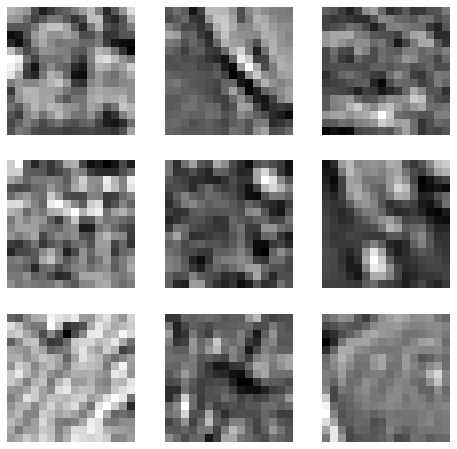

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img = (data[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().reshape([patch_size,patch_size]), cmap="gray")
plt.show()

In [17]:
# define random dictionary
n_basis = 100
n_features = patch_size**2
dictionary = torch.rand([n_features,n_basis])

# verify LCA method 
lca = inference.LCA(coeff_lr=1e-5)
lca.infer(data.patches[0:100,:],dictionary)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [-0., -0., -0.,  ..., 0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]])